# Emotion Detection with Accuracy 60%

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation

import re
import nltk
import string
import fasttext
from collections import Counter
from imblearn.over_sampling import SMOTE
from huggingface_hub import hf_hub_download
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from hazm import Normalizer, word_tokenize, stopwords_list, Lemmatizer,WordTokenizer
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Deep Learning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Masking
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Modelling
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, classification_report,f1_score

2025-08-02 22:18:24.228427: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
column_names = ['Text', 'Emotion']

train_data = pd.read_csv("/Users/macbookpro/Desktop/EmotionDetection/accuracy-60%/train_data.csv",header=None, names=column_names)
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_data

# train_data = pd.read_csv("/Users/macbookpro/Desktop/EmotionDetection/accuracy-50%/train.tsv", delimiter='\t', header=None, names=column_names, quotechar='"')
# test_data = pd.read_csv("/Users/macbookpro/Desktop/EmotionDetection/accuracy-50%/test.tsv", delimiter='\t', header=None, names=column_names, quotechar='"')
# train_data

,Text,Emotion
1808,پست تر از ادمی ک امیدواهی بهت میده و میدونه کا...,ANGRY
184,یکی اینجا هست که خیلی دوست دارم باهاش همصحبت ب...,SAD
205,بالاخره امروز حوصله کردم فوتبال ببینم,HAPPY
4700,جوری که با این آهنگ جو میگیرتمو هیچی ازم بعید ...,OTHER
410,در خریدش شک نکنید.بسیار عالی خوشبو .,HAPPY
...,...,...
4426,خود نمایندگی زرین قیمت مناسبتری داره,ANGRY
466,بریم بخوابیم که دِ اِرلی بِرْد کَچز دِ ورم. شب...,OTHER
3092,منم تعداد زیادی جمهوری خواه کونی می شناسم، دل...,ANGRY
3772,خیلی بی کیفیت. 10 روزه گارش تموم میشه و خراب میشه,ANGRY


In [3]:
train_data.info

<bound method DataFrame.info of                                                    Text Emotion
1808  پست تر از ادمی ک امیدواهی بهت میده و میدونه کا...   ANGRY
184   یکی اینجا هست که خیلی دوست دارم باهاش همصحبت ب...     SAD
205               بالاخره امروز حوصله کردم فوتبال ببینم   HAPPY
4700  جوری که با این آهنگ جو میگیرتمو هیچی ازم بعید ...   OTHER
410                در خریدش شک نکنید.بسیار عالی خوشبو .   HAPPY
...                                                 ...     ...
4426               خود نمایندگی زرین قیمت مناسبتری داره   ANGRY
466   بریم بخوابیم که دِ اِرلی بِرْد کَچز دِ ورم. شب...   OTHER
3092   منم تعداد زیادی جمهوری خواه کونی می شناسم، دل...   ANGRY
3772  خیلی بی کیفیت. 10 روزه گارش تموم میشه و خراب میشه   ANGRY
860      ماندگاری دقیقا در حد 2 ساعت و پخش بو هم ندارد.   ANGRY

[3939 rows x 2 columns]>

In [4]:
train_data.describe()

,Text,Emotion
count,3939,3939
unique,3939,5
top,پست تر از ادمی ک امیدواهی بهت میده و میدونه کا...,HAPPY
freq,1,1137


In [5]:
print(train_data.shape)
print(test_data.shape)

(3939, 2)
(985, 2)


In [6]:
# Check the balance
train_data.Emotion.value_counts()

Emotion
HAPPY    1137
OTHER    1021
ANGRY     825
SAD       679
FEAR      277
Name: count, dtype: int64

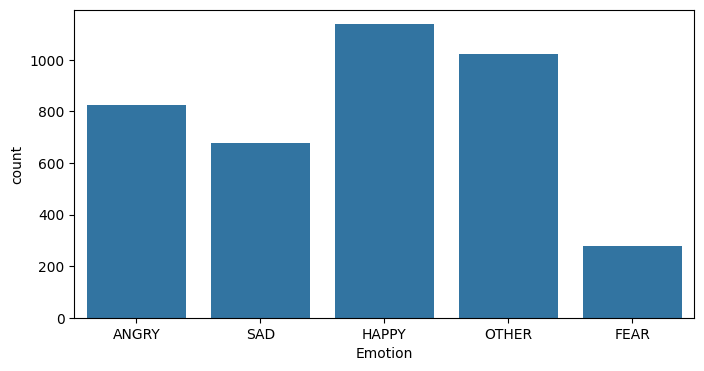

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=train_data);

In [8]:
# NULL values
print(train_data.isnull().sum())
print(train_data.duplicated().sum())

index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)
print(train_data.shape)

Text       0
Emotion    0
dtype: int64
0
(3939, 2)


In [9]:
# print the rows which are duplicated (duplicated in the text but with different emotions)
train_data[train_data['Text'].duplicated() == True]

,Text,Emotion


In [10]:
#removing duplicated text 
index = train_data[train_data['Text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)

In [11]:
#Count the number of stopwords in the data
normalizer = Normalizer()
lemmatizer = Lemmatizer()
persian_stopwords = set(stopwords_list())

temp =train_data.copy()
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(str(x).split()) & persian_stopwords)
)

print(temp['stop_words'].value_counts())

stop_words
3     870
2     774
4     645
1     563
5     412
6     245
0     226
7     118
8      46
9      29
10      9
11      2
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

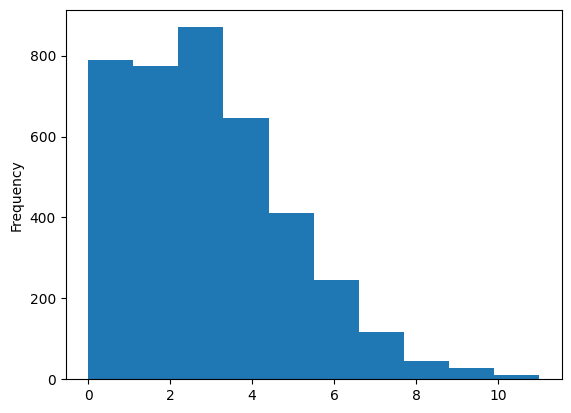

In [12]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

In [13]:
#check if the data is balanced or not
test_data.Emotion.value_counts()

Emotion
HAPPY    325
OTHER    242
ANGRY    187
SAD      166
FEAR      65
Name: count, dtype: int64

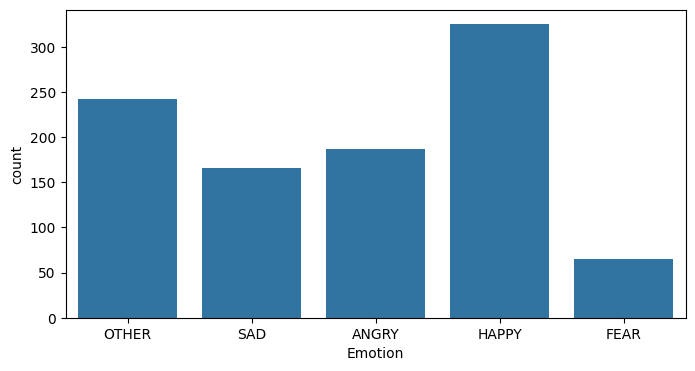

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=test_data);

In [15]:
#print the number of null values in each column
print(test_data.isnull().sum())
#print the number of duplicated values 
print(test_data.duplicated().sum())

Text       0
Emotion    0
dtype: int64
0


In [16]:
#print the rows which are duplicated
test_data[test_data['Text'].duplicated() == True]

,Text,Emotion


In [17]:
temp =test_data.copy()
temp['stop_words'] = temp['Text'].apply(
    lambda x: len(set(str(x).split()) & persian_stopwords)
)

print(temp['stop_words'].value_counts())

stop_words
3     200
2     197
4     176
1     133
5     108
6      70
0      44
7      33
8      17
9       4
10      2
11      1
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

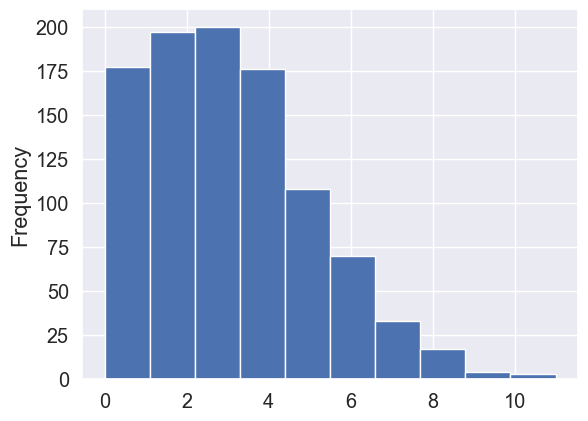

In [18]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

In [19]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    return diff_df

In [20]:
dataframe_difference(train_data, test_data, which='both')

,Text,Emotion,_merge


## Cleaning

In [21]:
import re
import numpy as np
from hazm import Normalizer, WordTokenizer, Lemmatizer, stopwords_list

# Hazm tools
normalizer = Normalizer()
lemmatizer = Lemmatizer()
persian_stopwords = set(stopwords_list())



# ============================
# Preprocessing Functions
# ============================

def remove_stop_words(text):
    words = [i for i in str(text).split() if i not in persian_stopwords]
    return " ".join(words)

def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

def to_lower_case(text):
    return " ".join([word.lower() for word in str(text).split()])

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', '')
    text = re.sub('\s+', ' ', text)
    return text.strip()

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def hazm_preprocess(text):
    text = normalizer.decrease_repeated_chars(text)
    text = normalizer.persian_number(text)
    text = normalizer.remove_diacritics(text)
    text = normalizer.correct_spacing(text)
    text = normalizer.normalize(text)
    return text

def hazm_lemmatize(text):
    return lemmatizer.lemmatize(text)

def normalized_sentence(sentence):
    sentence = str(sentence)
    sentence = to_lower_case(sentence)
    sentence = hazm_preprocess(sentence)
    sentence = remove_urls(sentence)
    sentence = remove_punctuations(sentence)
    sentence = remove_numbers(sentence)
    sentence = remove_stop_words(sentence)
    sentence = hazm_lemmatize(sentence)
    return sentence

# ============================
# Main Preprocessing Pipeline
# ============================

def normalize_text(df):
    df['Text'] = df['Text'].astype(str)
    df['Text'] = df['Text'].apply(to_lower_case)
    df['Text'] = df['Text'].apply(hazm_preprocess)
    df['Text'] = df['Text'].apply(remove_urls)
    df['Text'] = df['Text'].apply(remove_punctuations)
    df['Text'] = df['Text'].apply(remove_numbers)
    df['Text'] = df['Text'].apply(remove_stop_words)
    df['Text'] = df['Text'].apply(hazm_lemmatize)

    return df

def remove_small_sentences(df):
    df['Text'] = df['Text'].apply(lambda x: np.nan if len(str(x).split()) < 3 else x)



In [22]:
train_data= normalize_text(train_data)
test_data= normalize_text(test_data)

/var/folders/vs/t6hclhb524l53jbbc2n222640000gn/T/ipykernel_75158/2198372672.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Emotion', order=df['Emotion'].value_counts().index, palette='viridis')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


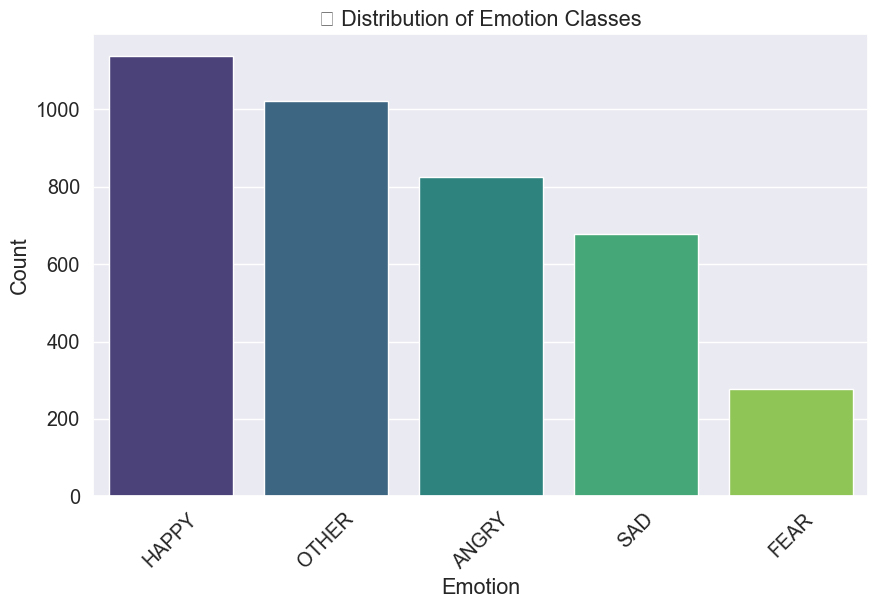

In [23]:
df = train_data  # or change to the correct DataFrame name if different

# 1. Label distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Emotion', order=df['Emotion'].value_counts().index, palette='viridis')
plt.title('🔍 Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [24]:
# 2. Preprocess text for token analysis
normalizer = Normalizer()
tokenizer = WordTokenizer()

def preprocess(text):
    text = normalizer.normalize(str(text))
    tokens = tokenizer.tokenize(text)
    return tokens

df['tokens'] = df['Text'].apply(preprocess)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


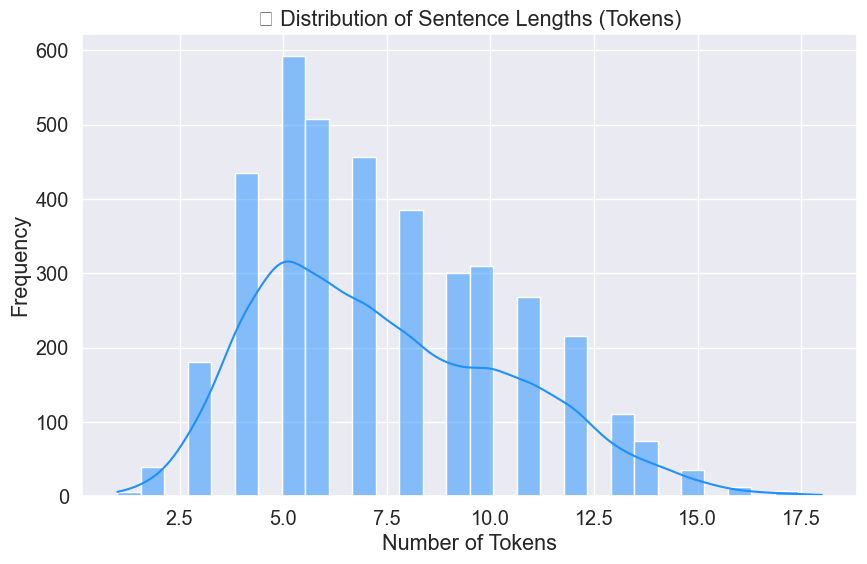

In [25]:
# 3. Sentence lengths
df['text_length'] = df['tokens'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=30, kde=True, color='dodgerblue')
plt.title('📏 Distribution of Sentence Lengths (Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


/var/folders/vs/t6hclhb524l53jbbc2n222640000gn/T/ipykernel_75158/4280974409.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='rocket')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


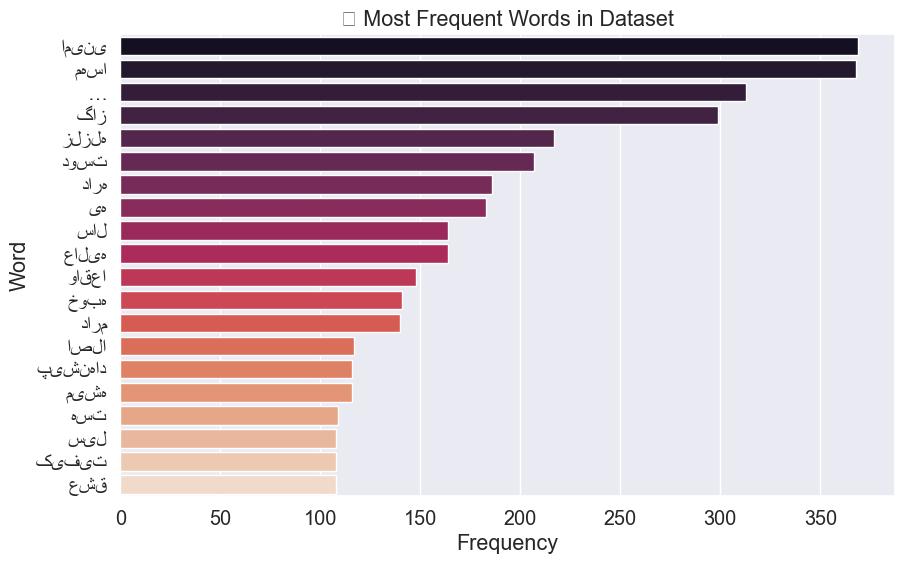

In [26]:
# 4. Most common words across all texts
from collections import Counter
all_tokens = [token for tokens in df['tokens'] for token in tokens]
most_common = Counter(all_tokens).most_common(20)

words, freqs = zip(*most_common)
plt.figure(figsize=(10,6))
sns.barplot(x=list(freqs), y=list(words), palette='rocket')
plt.title('🔤 Most Frequent Words in Dataset')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


## Modeling

In [27]:
X_train = train_data['Text'].values
y_train = train_data['Emotion'].values

X_test = test_data['Text'].values
y_test = test_data['Emotion'].values

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [29]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [30]:
# Vectorize training data first
from imblearn.over_sampling import SMOTE
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

# Apply SMOTE on vectorized data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_tfidf, y_train_encoded)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([
        ('clf', model)
    ])
    text_clf.fit(data, targets)
    return text_clf

In [32]:
from sklearn.metrics import f1_score
def get_F1(true,pred):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Calculate the F1 score for the predictions
    return f1_score(true, pred, average='weighted')

In [33]:
log_reg = train_model(
    LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=0),
    X_train_resampled,
    y_train_resampled
)

X_test_tfidf = tfidf.transform(X_test)


In [34]:
#test the model with the test data
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
y_pred_lr = log_reg.predict(X_test_tfidf)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test_encoded, y_pred_lr)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_lr = get_F1(y_test_encoded, y_pred_lr)
pd.DataFrame(f1_lr, index=le.classes_, columns=['F1 score'])

Accuracy:  0.550253807106599 



,F1 score
ANGRY,0.559493
FEAR,0.559493
HAPPY,0.559493
OTHER,0.559493
SAD,0.559493


In [35]:
print(classification_report(y_test_encoded, y_pred_lr, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.53      0.48      0.50       187
        FEAR       0.36      0.52      0.42        65
       HAPPY       0.82      0.66      0.74       325
       OTHER       0.47      0.45      0.46       242
         SAD       0.41      0.57      0.48       166

    accuracy                           0.55       985
   macro avg       0.52      0.54      0.52       985
weighted avg       0.58      0.55      0.56       985



In [36]:
#Train the model with the training data
X_train_tfidf_orig = tfidf.transform(X_train)
DT = train_model(DecisionTreeClassifier(random_state=0), X_train_tfidf_orig, y_train_encoded)
#test the model with the test data
y_pred_dt = DT.predict(X_test_tfidf)

#calculate the accuracy
DT_accuracy =accuracy_score(y_test_encoded, y_pred_dt)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_dt = get_F1(y_test_encoded, y_pred_dt)
pd.DataFrame(f1_dt, index=le.classes_, columns=['F1 score'])

Accuracy:  0.5218274111675127 



,F1 score
ANGRY,0.517981
FEAR,0.517981
HAPPY,0.517981
OTHER,0.517981
SAD,0.517981


In [37]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_dt, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.45      0.40      0.42       187
        FEAR       0.41      0.35      0.38        65
       HAPPY       0.66      0.72      0.69       325
       OTHER       0.44      0.44      0.44       242
         SAD       0.46      0.46      0.46       166

    accuracy                           0.52       985
   macro avg       0.48      0.47      0.48       985
weighted avg       0.52      0.52      0.52       985



In [38]:
#Train the model with the training data
SVM = train_model(SVC(C=1.0, kernel='linear', probability=True,class_weight='balanced'), X_train_tfidf, y_train_encoded)

#test the model with the test data
y_pred_svm = SVM.predict(X_test_tfidf)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test_encoded, y_pred_svm)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_svm)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score'])

Accuracy:  0.5634517766497462 



,F1 score
ANGRY,0.57252
FEAR,0.57252
HAPPY,0.57252
OTHER,0.57252
SAD,0.57252


In [39]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_svm, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.50      0.53      0.51       187
        FEAR       0.40      0.58      0.47        65
       HAPPY       0.84      0.65      0.74       325
       OTHER       0.45      0.47      0.46       242
         SAD       0.49      0.56      0.52       166

    accuracy                           0.56       985
   macro avg       0.54      0.56      0.54       985
weighted avg       0.59      0.56      0.57       985



In [40]:
#Train the model with the training data
RF =train_model(RandomForestClassifier(n_estimators=200, max_depth=50, class_weight='balanced'), X_train_tfidf, y_train_encoded)

#test the model with the test data
y_pred_rf = RF.predict(X_test_tfidf)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_rf)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score']) 

Accuracy:  0.5411167512690356 



,F1 score
ANGRY,0.550696
FEAR,0.550696
HAPPY,0.550696
OTHER,0.550696
SAD,0.550696


In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.47      0.44      0.46       187
        FEAR       0.56      0.55      0.56        65
       HAPPY       0.82      0.63      0.71       325
       OTHER       0.40      0.53      0.46       242
         SAD       0.47      0.49      0.48       166

    accuracy                           0.54       985
   macro avg       0.54      0.53      0.53       985
weighted avg       0.57      0.54      0.55       985



: 

In [ ]:
import xgboost as xgb
# =(RandomForestClassifier(n_estimators=200, max_depth=50, class_weight='balanced'), X_train_tfidf, y_train_encoded)

XGB = train_model(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0),X_train_resampled, y_train_resampled)
# xgb_clf.fit()
y_pred_XGB = XGB.predict(X_test_tfidf)
XGB_accuracy = accuracy_score(y_test_encoded, y_pred_XGB)
print('Accuracy: ', XGB_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(y_test_encoded, y_pred_XGB)
pd.DataFrame(f1_Score, index=le.classes_, columns=['F1 score']) 

In [ ]:
##Classification Report
print(classification_report(y_test_encoded, y_pred_XGB, target_names=le.classes_))

              precision    recall  f1-score   support

       ANGRY       0.51      0.37      0.43       154
        FEAR       0.61      0.72      0.66        57
       HAPPY       0.63      0.40      0.49       275
        HATE       0.34      0.28      0.31        65
       OTHER       0.32      0.68      0.43       193
         SAD       0.53      0.52      0.52       262
    SURPRISE       0.56      0.30      0.39       145

    accuracy                           0.46      1151
   macro avg       0.50      0.47      0.46      1151
weighted avg       0.51      0.46      0.46      1151



In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        round(log_reg_accuracy, 2),
        round(DT_accuracy, 2),
        round(SVM_accuracy, 2),
        round(RF_accuracy, 2),
        round(XGB_accuracy, 2)
    ],    'F1 Score (Weighted)': [
        round(get_F1(y_test_encoded, y_pred_lr), 2),
        round(get_F1(y_test_encoded, y_pred_dt), 2),
        round(get_F1(y_test_encoded, y_pred_svm), 2),
        round(get_F1(y_test_encoded, y_pred_rf), 2),
        round(get_F1(y_test_encoded, y_pred_XGB), 2)
    ]
})
models_sorted = models.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
models_sorted


,Model,Accuracy,F1 Score (Weighted)
0,XGBoost,0.46,0.46
1,Logistic Regression,0.45,0.44
2,Support Vector Machine,0.45,0.44
3,Random Forest,0.38,0.37
4,Decision Tree,0.36,0.36


In [ ]:
best_model_name = models_sorted.loc[0, 'Model']  # gets model with highest accuracy
print("Best model is:", best_model_name)

Best model is: XGBoost


In [ ]:

from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

## LIME

In [ ]:
#c_LR = make_pipeline(tfidf, clf)
from sklearn.pipeline import make_pipeline
idx  = 1
Result_pipeline = make_pipeline(tfidf, XGB.named_steps['clf']) 
pred_label = le.inverse_transform(Result_pipeline.predict([X_test[idx]]))[0]
actual_label = y_test[idx]  # already a string

explainer = LimeTextExplainer(class_names=le.classes_)
print("Actual Text : ", X_test[idx])
print("Prediction : ", pred_label)     
print("Actual     : ", actual_label)

exp = explainer.explain_instance(X_test[idx], Result_pipeline.predict_proba, top_labels=5)
exp.show_in_notebook()


Actual Text :  دیشب ارسال تویت آثار باستانی تویت نوشتم هرچه منتظر شدم ارسال نشد همون موقع الان تویتر نداشتم ناراحت بودم نکنه پیامی باشین ومن نبینم الحمدالله خبری خبر نبودم خوش گذشته
Prediction :  SAD
Actual     :  HAPPY


## New Modeling

In [ ]:
#Splitting the text from the labels
X_train = train_data['Text']
y_train = train_data['Emotion']

X_test = test_data['Text']
y_test = test_data['Emotion']

X_train

0              کوچیک هستن سایزشون بدرد نمیخوره میخوام بدم
1             صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم
2       کیفیتش خوبه شک خریدم واقعا راضیم ماه استفاده «...
3       همش دوربین ثبت‌شده ایا میشه اعتراض زد اصن تاثی...
4                         وضع ب طرز خنده داری گریه داره …
                              ...                        
6076    مرحوم پیش‌بینی آبکی مرحوم عجب آینده‌نگری پیش‌ب...
6077    کلا اعتقادات توئیت زدناتون … قبال رانت نون مفت...
6078    خب میگی بیاد مارو بگیره یارو ترس میکنه یکم دوس...
6079    همون هارو مگه آهنگ جدیدای خواننده‌های پنجاه گو...
6080                                  نیم دگیرش چطور نیشد
Name: Text, Length: 6081, dtype: object

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
print(set(y_train))

{0, 1, 2, 3, 4, 5, 6}


In [ ]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# Compute weights
weights = compute_class_weight(class_weight='balanced',
                               classes=np.unique(y_train),
                               y=y_train)

class_weights = dict(enumerate(weights))

# Now compute sample_weight
sample_weights = np.array([class_weights[i] for i in y_train])

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


## Tokenizing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

import re

def normalize_persian(text):
    # Replace Arabic characters with Persian
    text = re.sub("ي", "ی", text)
    text = re.sub("ك", "ک", text)
    # Remove diacritics
    text = re.sub("[ًٌٍَُِّْٰ]", "", text)
    return text.lower()

# Normalize before fitting
normalized_text = pd.concat([X_train, X_test], axis=0).apply(normalize_persian)
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(normalized_text)

# tokenizer = Tokenizer(oov_token='UNK')
# tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

tokenizer.document_count

6015

In [ ]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences([X_train.iloc[0]])

#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

## Padding

In [ ]:
test_data.shape

(1151, 2)

In [ ]:
maxlen = max([len(t) for t in train_data['Text']])
maxlen

2312

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = max(len(seq) for seq in sequences_train)

X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 22837


In [ ]:
#before
sequences_train[0]

[1933,
 157,
 43,
 8727,
 8728,
 201,
 8729,
 424,
 972,
 250,
 2909,
 138,
 1361,
 2515,
 587,
 1707,
 731,
 2910,
 5680,
 138,
 250,
 14,
 327,
 817,
 262,
 2,
 424,
 588,
 424,
 1934,
 908,
 424,
 1708,
 8730]

In [ ]:
#after
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Word Embedding

In [ ]:
import numpy as np
import fasttext
from huggingface_hub import hf_hub_download
# Download the file to a local path
model_path = hf_hub_download(
    repo_id="taesiri/PersianWordVecs",
    filename="farsi-dedup-cbow.bin"
)
# Load pre-trained Persian FastText model
fasttext_model = fasttext.load_model(model_path)

: 

: 

In [ ]:
embedding_dim = 100  # FastText Persian models usually use 300 dimensions
vocabSize = len(tokenizer.word_index) + 1  # Use your tokenizer's vocab size

embedding_matrix = np.zeros((vocabSize, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocabSize:
        continue
    embedding_matrix[i] = fasttext_model.get_word_vector(word)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (22837, 100)


In [ ]:
from tensorflow.keras.models import load_model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
num_tokens = vocabSize
hits=0
misses=0
for word, i in tokenizer.word_index.items():
    if i >= num_tokens:
        continue
    try:
        embedding_vector = fasttext_model.get_word_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    except:
        misses += 1

print(f"Converted {hits} words ({misses} misses) into embedding vectors.")

Converted 22836 words (0 misses) into embedding vectors.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


# Compile
max_len = 100  # Use a reasonable max length, not too long

model = Sequential()
model.add(
    Embedding(
        input_dim=vocabSize,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # freeze embeddings first
    )
)
model.add(Masking(mask_value=0.0))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax', kernel_regularizer=l2(0.01)))

adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_m])

model.summary()



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,283,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,283,700 (8.71 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,283,700 (8.71 MB)

Python(69020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


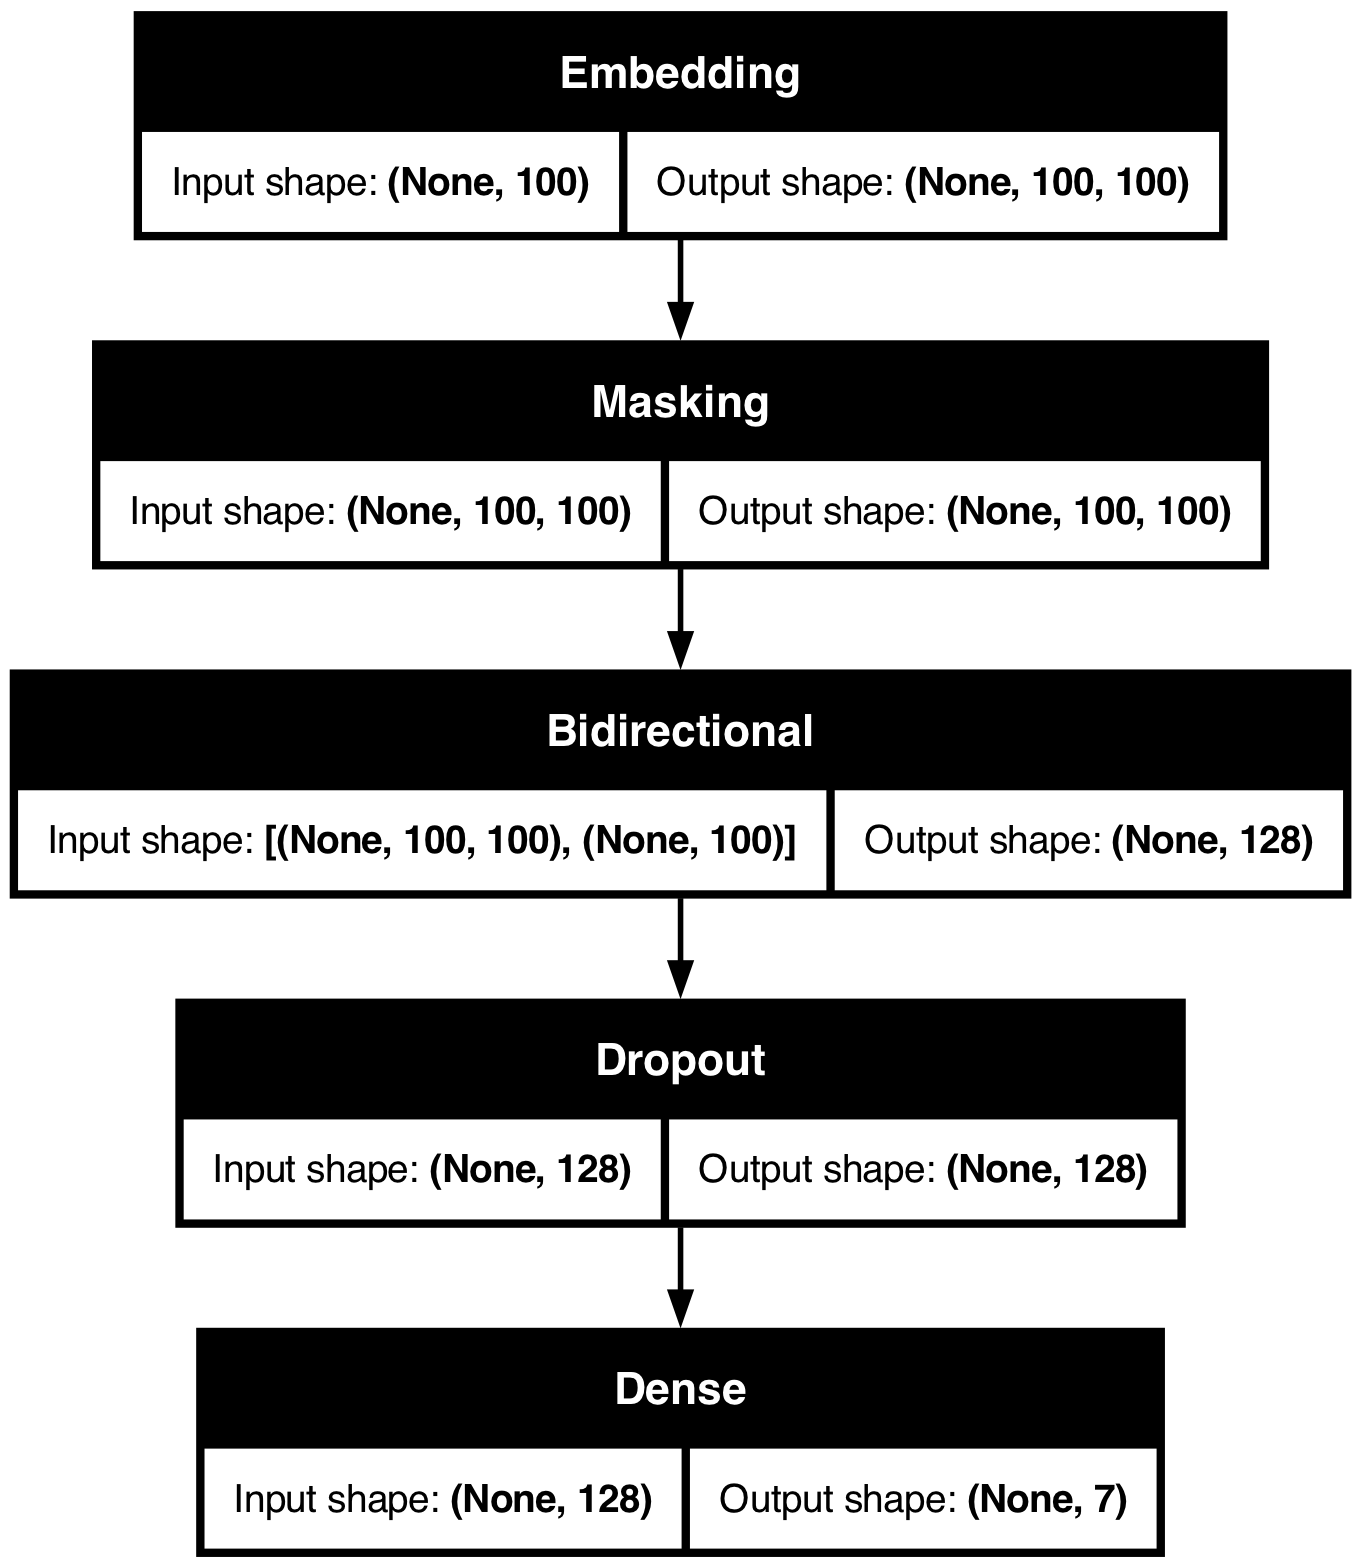

In [ ]:
import tensorflow as tf
model.build(input_shape=(None, 100))
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras import backend as K
#to stop the training when the loss starts to increase
callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Fit model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,  # your computed dict from earlier
    callbacks=[callback],
    verbose=1
)

Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 60s 331ms/step - accuracy: 0.1684 - f1_m: 0.0060 - loss: 2.1346 - val_accuracy: 0.3353 - val_f1_m: 0.0307 - val_loss: 1.8518
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 74s 486ms/step - accuracy: 0.3047 - f1_m: 0.0599 - loss: 1.8077 - val_accuracy: 0.4322 - val_f1_m: 0.1204 - val_loss: 1.6742
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 531ms/step - accuracy: 0.4146 - f1_m: 0.1550 - loss: 1.5997 - val_accuracy: 0.4618 - val_f1_m: 0.2486 - val_loss: 1.5449
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 508ms/step - accuracy: 0.4577 - f1_m: 0.2815 - loss: 1.4588 - val_accuracy: 0.5012 - val_f1_m: 0.3027 - val_loss: 1.4747
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 514ms/step - accuracy: 0.4910 - f1_m: 0.3319 - loss: 1.3746 - val_accuracy: 0.5283 - val_f1_m: 0.3550 - val_loss: 1.4084
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 113s 746ms/step - accuracy: 0.5342 - f1_m: 0.4081 - loss: 1.2631 - val_accuracy: 0.5292 - val_f1_m: 0.3951 - val_loss: 1.3705
Epoch 7/3

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5678 - f1_m: 0.4871 - loss: 1.2906


[1.3228732347488403, 0.5546425580978394, 0.4656021296977997]

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5140 - f1_m: 0.4305 - loss: 1.3996


[1.4262418746948242, 0.4874022603034973, 0.41807401180267334]

In [ ]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(test_data['Emotion']), y_pred))

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       154
           1       0.55      0.63      0.59        57
           2       0.59      0.53      0.56       275
           3       0.26      0.29      0.28        65
           4       0.36      0.65      0.47       193
           5       0.59      0.48      0.53       262
           6       0.60      0.21      0.31       145

    accuracy                           0.49      1151
   macro avg       0.49      0.47      0.46      1151
weighted avg       0.52      0.49      0.48      1151



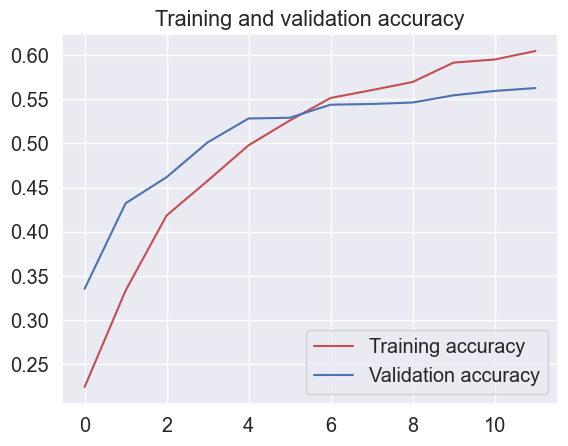

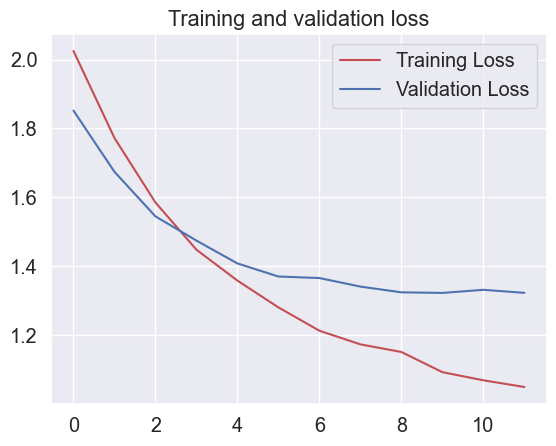

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
# Classify custom sample

sentences = [
             "با اینکار خوشحال شدم",
            "اه تف به این زندگی",
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

با اینکار خوشحال شدم
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
HAPPY : 0.6097015738487244


اه تف به این زندگی
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
ANGRY : 0.5421184301376343


